# ERA5 Soundings

```{image} ../thumbnails/sounderpy_logo.png
:alt: Sounderpy logo
:width: 150px
:height: 100px
```

---

## Overview

Upper-air soundings provide a detailed view of the thermodynamic and kinematic structure of the atmosphere—information essential for understanding how thunderstorms form, intensify, or weaken. In this notebook, we use **SounderPy** together with **ERA5 reanalysis data** (accessed remotely from the DestinE EarthDataHub) to build and visualize vertical atmospheric profiles for two severe-weather events in the northeastern United States:

- **New Hampshire tornado — 05 May 2018**  
- **New Jersey tornado — 29 July 2021**

These ERA5-based soundings allow us to examine the storm environment even when no nearby observed balloon data are available.

The notebook is organized into the following sections:

1. **Import required packages**  
2. **Load ERA5 data from the DestinE EarthDataHub**  
3. **Extract vertical profiles for specific events**  
4. **Visualize complete soundings**  
 
This workflow provides a comprehensive look at the environments associated with two real tornado events, using high-resolution reanalysis data to reconstruct conditions where observed soundings may be missing or distant.

## Prerequisites

This notebook assumes that the reader has a basic understanding of atmospheric thermodynamics and Python-based data analysis.  
The workflow focuses on retrieving upper-air profiles from **DestinE ERA5 reanalysis**, processing them with **SounderPy**, and visualizing the resulting thermodynamic and kinematic structures.

The table below outlines the prerequisite concepts and their relevance to this analysis.

| Concepts | Importance | Notes |
|---------|------------|-------|
| **Intro to Soundings & Thermodynamics** | Necessary | Familiarity with pressure–temperature profiles, CAPE/CIN and lapse rates helps interpret sounding structure. |
| **Understanding Reanalysis Data (ERA5)** | Necessary | ERA5 is the source dataset for all model-derived soundings used in this notebook. |
| **Intro to SounderPy** | Necessary | SounderPy handles profile processing, cleaning, parcel calculations, and Skew-T/hodograph plotting. See the [SounderPy GitHub](https://github.com/kylejgillett/sounderpy). |
| **Basic Xarray Usage** | Helpful | Required for selecting latitude, longitude, and time slices from the DestinE ERA5 dataset. |
| **Basic MetPy Usage** | Helpful | Used to convert variables (e.g., geopotential → height, specific humidity → dewpoint). |
| **Intro to Matplotlib** | Optional | SounderPy handles plotting automatically, but Matplotlib knowledge can help with customization. |

- **Time to learn**: ≈ 20–30 minutes  
(*around 5 minutes per subsection depending on familiarity*) 

---

## Imports

In [1]:
import numpy as np
import xarray as xr
import metpy.calc as mpcalc
from metpy.units import units
import sounderpy as spy
import ipywidgets as widgets
from ipywidgets import HBox, VBox
from IPython.display import display, clear_output
import matplotlib.pyplot as plt


## ---------------------------------- SOUNDERPY ----------------------------------- ##
##          Vertical Profile Data Retrieval and Analysis Tool For Python            ##
##                    v3.0.9 | August 2025 | (C) Kyle J Gillett                     ##
##                 Docs: https://kylejgillett.github.io/sounderpy/                  ##
## --------------------- THANK YOU FOR USING THIS PACKAGE! ------------------------ ##



## Data Retrieval

### Data Sources

This project uses **reanalysis upper-air soundings** rather than observed balloon launches.  
Specifically, we access the **DestinE ERA5 Pressure-Level Reanalysis**, a cloud-optimized public dataset that streams directly into Python without requiring local downloads.

### DestinE ERA5 Reanalysis
- Global ERA5 pressure-level fields (temperature, humidity, winds, geopotential, pressure).
- Accessible as a **public Zarr store**, ideal for rapid, on-the-fly profile extraction.
- Works seamlessly with `xarray` and SounderPy for building full atmospheric soundings.

**Access URL:**  
https://data.earthdatahub.destine.eu/era5/reanalysis-era5-pressure-levels-v0.zarr

We use DestinE ERA5 to generate vertical profiles at the exact storm locations and times for the NH and NJ tornado cases.

In [2]:
#Open DestinE ERA5 pressure-level dataset

ds = xr.open_dataset(
    "https://data.earthdatahub.destine.eu/era5/reanalysis-era5-pressure-levels-v0.zarr",
    storage_options={"client_kwargs":{"trust_env":True}},
    chunks={},
    engine="zarr",
)

print(f'size: {ds.nbytes / (1024 ** 4)} TB')

size: 863.9610183753794 TB


### Examine the datasets

In [3]:
ds

<xarray.Dataset> Size: 950TB
Dimensions:        (valid_time: 752424, isobaricInhPa: 19, latitude: 721,
                    longitude: 1440)
Coordinates:
  * valid_time     (valid_time) datetime64[ns] 6MB 1940-01-01 ... 2025-10-31T...
  * isobaricInhPa  (isobaricInhPa) int32 76B 1000 925 850 700 600 ... 20 10 5 1
  * latitude       (latitude) float64 6kB 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
  * longitude      (longitude) float64 12kB 0.0 0.25 0.5 ... 359.2 359.5 359.8
    number         int64 8B ...
Data variables: (12/16)
    cc             (valid_time, isobaricInhPa, latitude, longitude) float32 59TB dask.array<chunksize=(120, 1, 256, 256), meta=np.ndarray>
    ciwc           (valid_time, isobaricInhPa, latitude, longitude) float32 59TB dask.array<chunksize=(120, 1, 256, 256), meta=np.ndarray>
    clwc           (valid_time, isobaricInhPa, latitude, longitude) float32 59TB dask.array<chunksize=(120, 1, 256, 256), meta=np.ndarray>
    crwc           (valid_time, isobaricInhPa, latitude, longitude) float32 59TB dask.array<chunksize=(120, 1, 256, 256), meta=np.ndarray>
    cswc           (valid_time, isobaricInhPa, latitude, longitude) float32 59TB dask.array<chunksize=(120, 1, 256, 256), meta=np.ndarray>
    d              (valid_time, isobaricInhPa, latitude, longitude) float32 59TB dask.array<chunksize=(120, 1, 256, 256), meta=np.ndarray>
    ...             ...
    t              (valid_time, isobaricInhPa, latitude, longitude) float32 59TB dask.array<chunksize=(120, 1, 256, 256), meta=np.ndarray>
    u              (valid_time, isobaricInhPa, latitude, longitude) float32 59TB dask.array<chunksize=(120, 1, 256, 256), meta=np.ndarray>
    v              (valid_time, isobaricInhPa, latitude, longitude) float32 59TB dask.array<chunksize=(120, 1, 256, 256), meta=np.ndarray>
    vo             (valid_time, isobaricInhPa, latitude, longitude) float32 59TB dask.array<chunksize=(120, 1, 256, 256), meta=np.ndarray>
    w              (valid_time, isobaricInhPa, latitude, longitude) float32 59TB dask.array<chunksize=(120, 1, 256, 256), meta=np.ndarray>
    z              (valid_time, isobaricInhPa, latitude, longitude) float32 59TB dask.array<chunksize=(120, 1, 256, 256), meta=np.ndarray>
Attributes:
    Conventions:             CF-1.7
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_edition:            1
    GRIB_subCentre:          0
    history:                 2024-11-15T16:05 GRIB to CDM+CF via cfgrib-0.9.1...
    institution:             European Centre for Medium-Range Weather Forecasts

### Build SounderPy Profiles from DestinE ERA5

I asked ChatGPT to help create a small helper function that extracts a vertical atmospheric profile from the DestinE ERA5 dataset and converts it into the `clean_data` format required by SounderPy. This ensures consistent processing for each event and avoids repeating the same steps for every sounding.

In [4]:
def make_clean_sounding(ds, time_str, lat, lon_deg, site_id, site_name, site_label):
    """
    Create a SounderPy clean_data dict from DestinE ERA5 pressure-level data.

    time_str : ISO time string, e.g. "2018-05-05T01:00"
    lat      : latitude  (degrees)
    lon_deg  : longitude (degrees, -180..180)
    """
    # Convert lon to 0–360 for ERA5 grid
    lon_era = lon_deg if lon_deg >= 0 else 360.0 + lon_deg
    dt = np.datetime64(time_str)

    # 1. Select profile at nearest grid point
    # DestinE uses 'valid_time' instead of 'time'
    prof = ds.sel(
        valid_time=dt,
        latitude=lat,
        longitude=lon_era,
        method="nearest"
    ).squeeze()

    print(f"\nUsing grid point for {site_id}:")
    print("  TIME:", prof.valid_time.values)
    print("  LAT :", float(prof.latitude.values))
    print("  LON :", float(prof.longitude.values))

    # 2. Pull variables (check names: usually t, q, u, v, z)
    temperature = prof["t"].values * units.kelvin
    T = temperature.to("degC")

    # pressure levels (hPa)
    p = prof["isobaricInhPa"].values * units.hectopascal

    # specific humidity (kg/kg)
    q = prof["q"].values * units("kg/kg")

    # winds (m/s -> kt)
    u = prof["u"].values * units("m/s")
    v = prof["v"].values * units("m/s")
    u = u.to("knot")
    v = v.to("knot")

    # geopotential (m^2/s^2 -> m)
    z_gh = mpcalc.geopotential_to_height(
        prof["z"].values * units("m**2/s**2")
    ).to("meter")

    # dewpoint from p, T, q
    Td = mpcalc.dewpoint_from_specific_humidity(p, temperature, q)

    # 3. Sort by decreasing pressure (surface at bottom)
    sort_idx = np.argsort(p)[::-1]
    p    = p[sort_idx]
    T    = T[sort_idx]
    Td   = Td[sort_idx]
    u    = u[sort_idx]
    v    = v[sort_idx]
    z_gh = z_gh[sort_idx]

    # 4. Build clean_data dict
    clean_data = {}
    clean_data["p"]  = p
    clean_data["z"]  = z_gh
    clean_data["T"]  = T
    clean_data["Td"] = Td
    clean_data["u"]  = u
    clean_data["v"]  = v

    # convert lon back to -180..180 for display
    lon_plot = float(prof.longitude.values)
    if lon_plot > 180.0:
        lon_plot = lon_plot - 360.0

    clean_data["site_info"] = {
        "site-id"    : site_id,
        "site-name"  : site_name,
        "site-lctn"  : site_label,
        "site-latlon": [float(prof.latitude.values), lon_plot],
        "site-elv"   : float(z_gh[-1].m),  # approximate lowest-level height
        "source"     : "ERA5 Reanalysis (DestinE EarthDataHub)",
        "model"      : "ERA5",
        "fcst-hour"  : "none",
        "run-time"   : ["none", "none", "none", "none"],
        "valid-time" : [prof.valid_time.values],
    }

    clean_data["titles"] = {
        "top_title": "ERA5 Modeled Sounding",
        "left_title": f"VALID: {prof.valid_time.values}",
        "right_title": (
            f"{site_label}\n"
            f"LAT: {float(prof.latitude.values):.2f}   "
            f"LON: {lon_plot:.2f}"
        ),
    }

    return clean_data

### Extracting ERA5 Soundings for Tornado Case Studies

We generate model-derived atmospheric soundings for two tornado environments by calling the helper function `make_clean_sounding()`. Each call retrieves a vertical profile from DestinE ERA5 at the specified event time and storm start location.


In [5]:
# New Hampshire tornado (2018-05-05 near 01:18 UTC) 
nh_clean = make_clean_sounding(
    ds,
    time_str="2018-05-05T01:00",
    lat=43.15,
    lon_deg=-72.45,
    site_id="NH_TORNADO",
    site_name="New Hampshire Tornado Environment",
    site_label="New Hampshire Tornado Env (Start Point)"
)

# New Jersey tornado (2021-07-29, 21:59–22:14 UTC) 
nj_clean = make_clean_sounding(
    ds,
    time_str="2021-07-29T22:00",
    lat=40.35,
    lon_deg=-74.95,
    site_id="NJ_TORNADO",
    site_name="New Jersey Tornado Environment",
    site_label="New Jersey Tornado Env (Start Point)"
)


Using grid point for NH_TORNADO:
  TIME: 2018-05-05T01:00:00.000000000
  LAT : 43.25
  LON : 287.5

Using grid point for NJ_TORNADO:
  TIME: 2021-07-29T22:00:00.000000000
  LAT : 40.25
  LON : 285.0


### Plot and Visualize event soundings

Soundings close to the time of the event 

> SOUNDING PLOTTER FUNCTION
  ---------------------------------


Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


    > COMPLETE --------
    > RUNTIME: 00:00:01


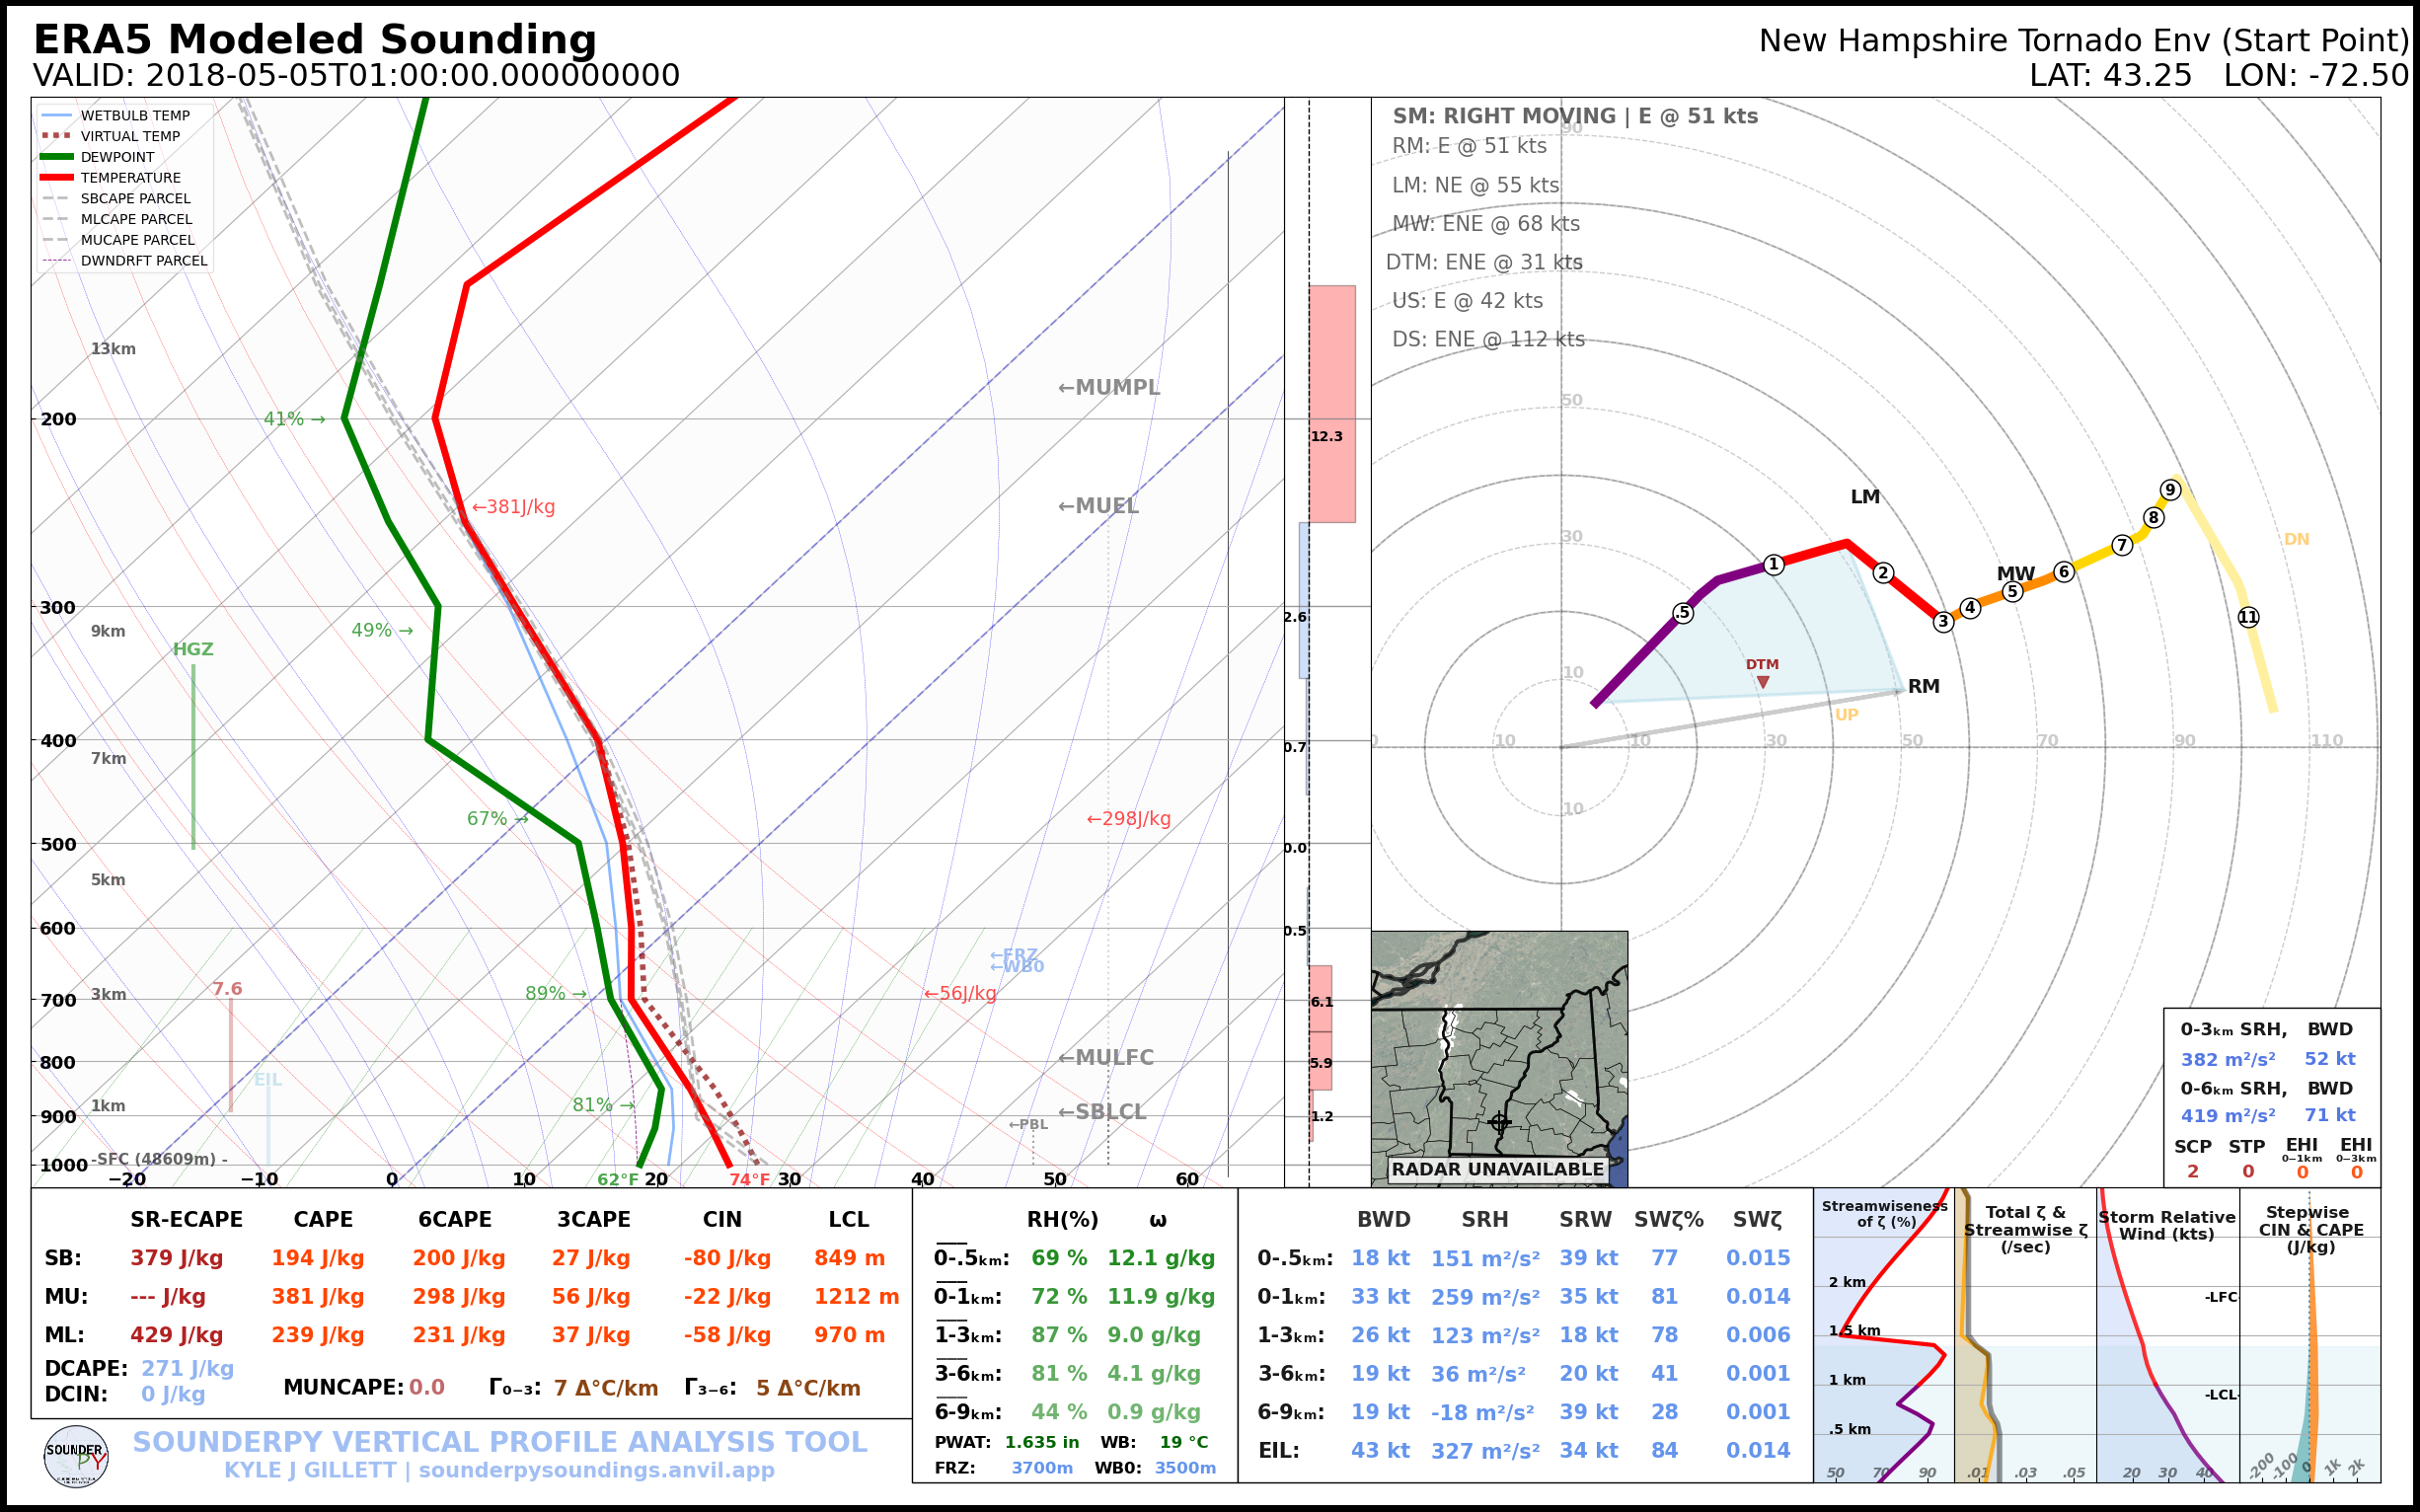

> SOUNDING PLOTTER FUNCTION
  ---------------------------------


Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


    > COMPLETE --------
    > RUNTIME: 00:00:27


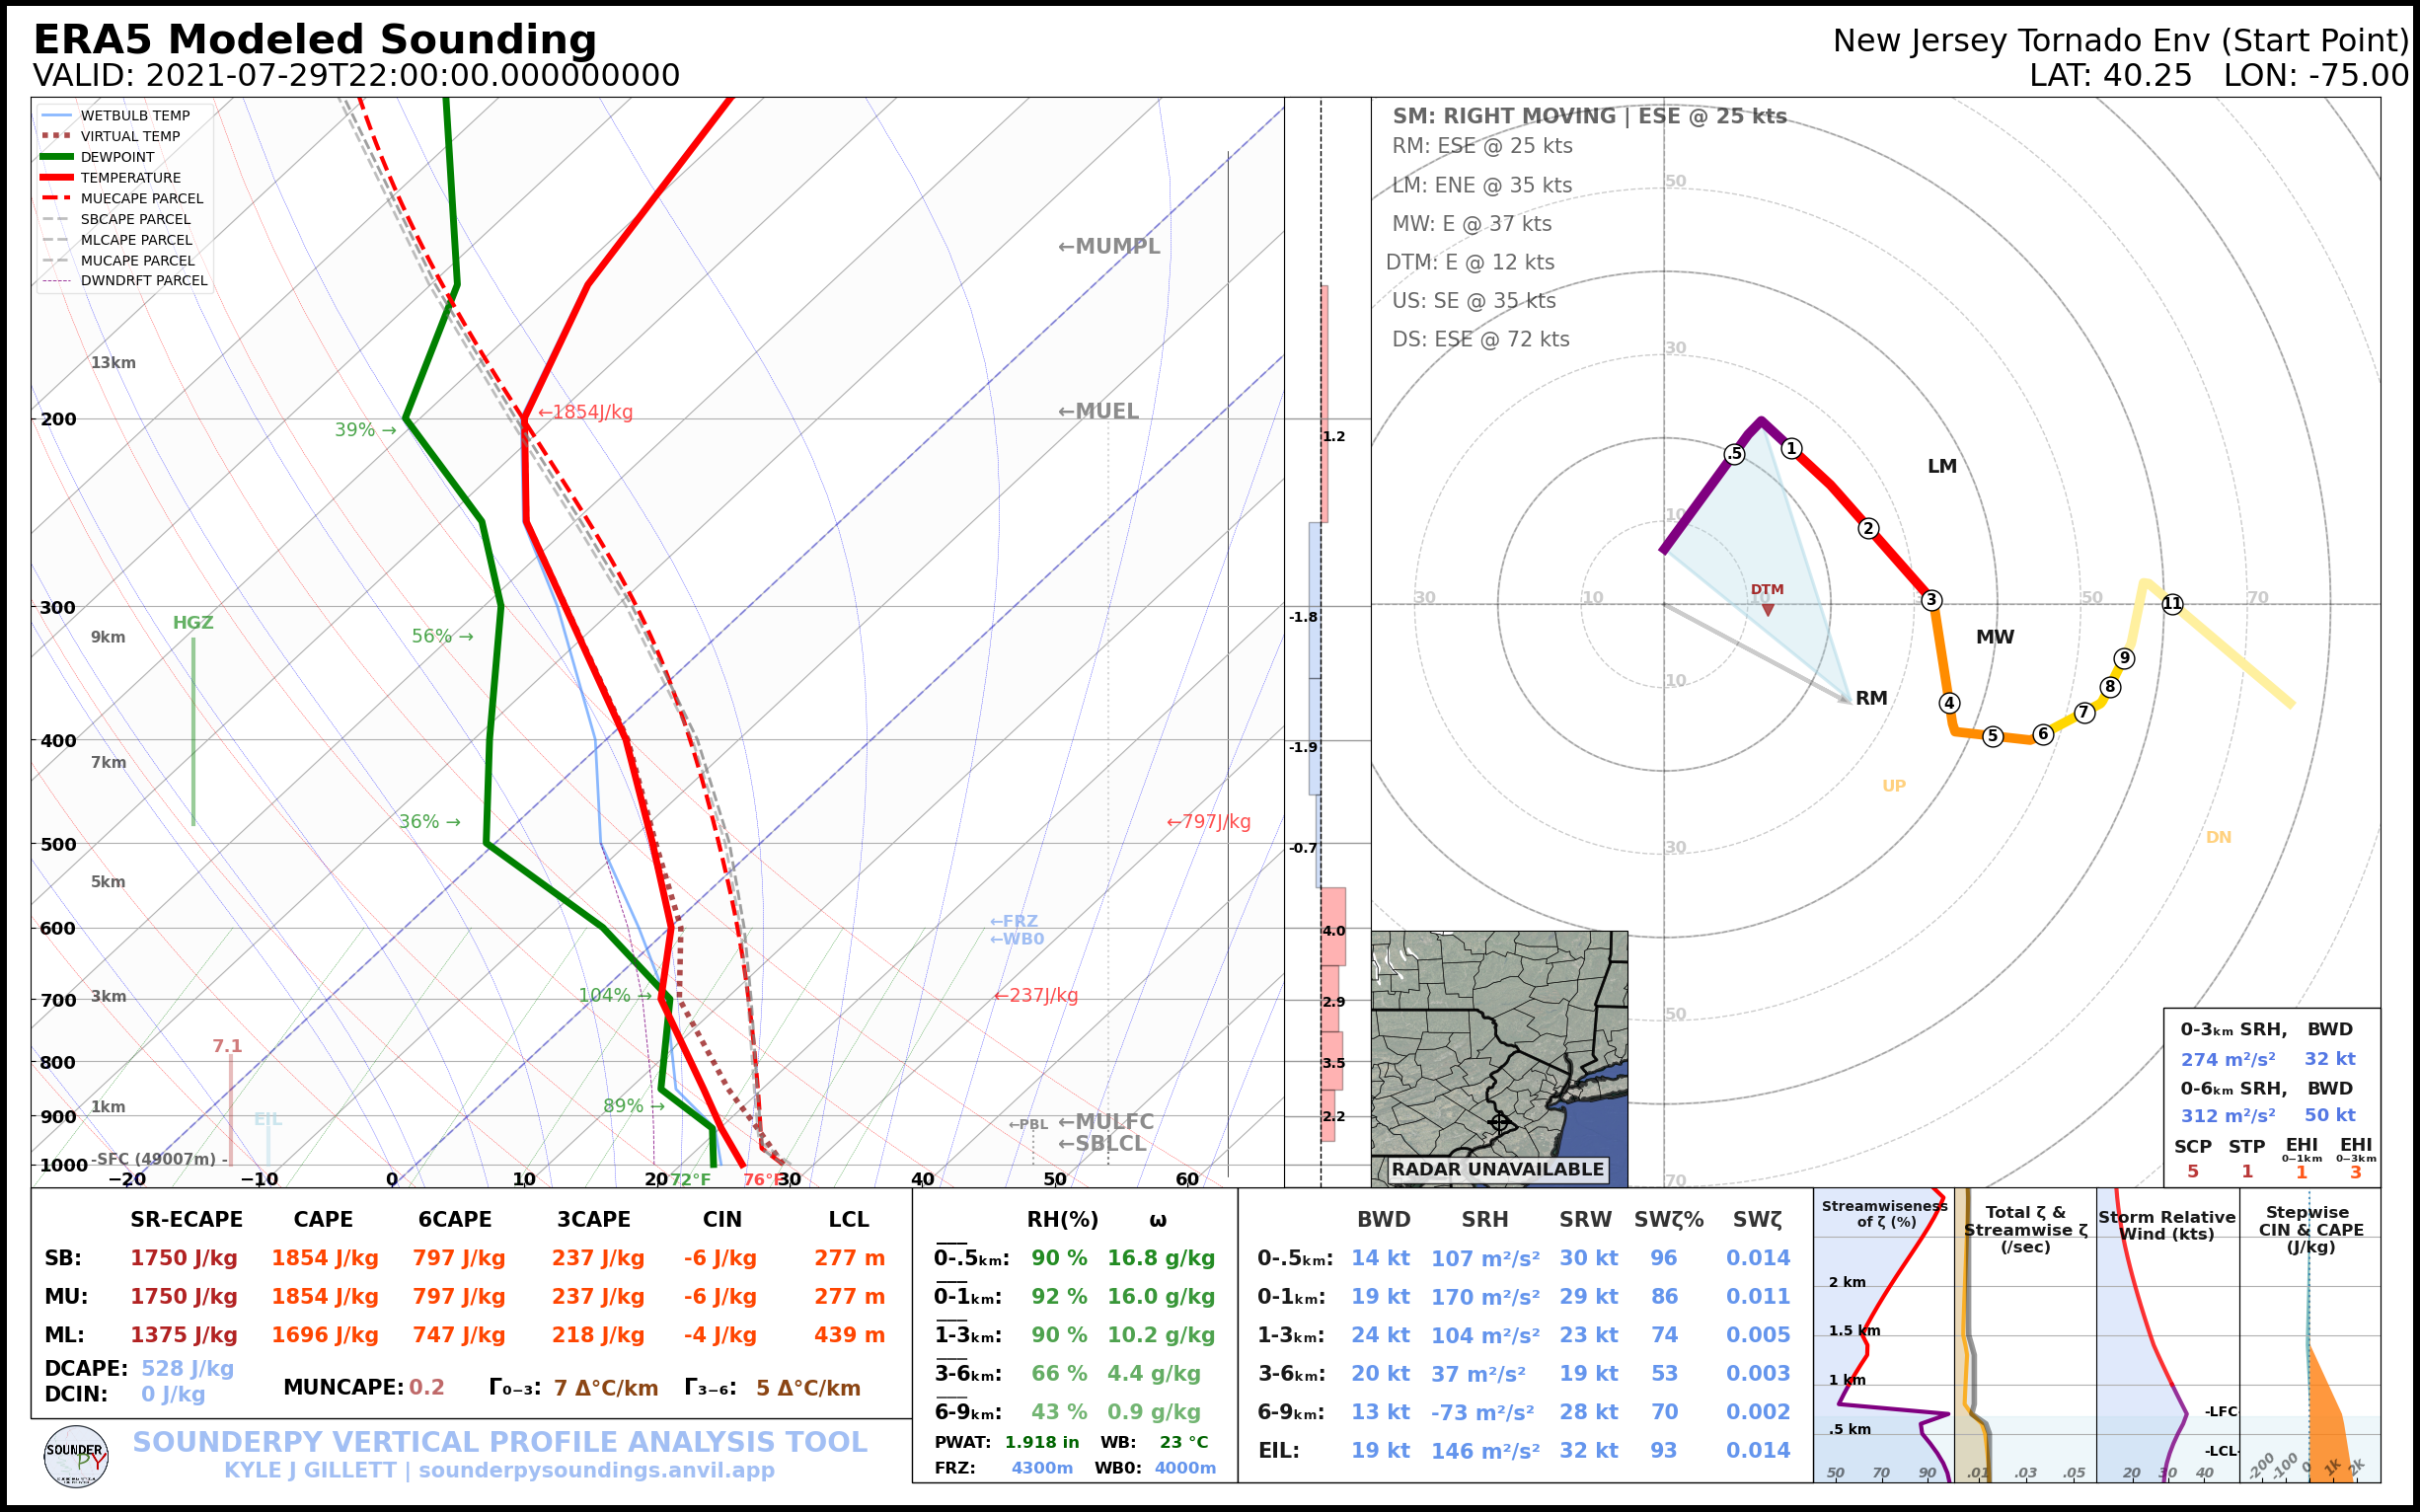

In [6]:
spy.build_sounding(nh_clean)  # NH plot
spy.build_sounding(nj_clean)  # NJ plot

### Animate evolution of event soundings

To explore how the pre-storm environment evolved leading up to each tornadic event, I implemented an interactive animated sounding viewer. Using a helper function and a time loop, multiple consecutive soundings are generated and displayed through a slider-based interface. This setup allows the user to scroll through each hour and visually step through changes in temperature, moisture, and wind structure leading into the tornado. ChatGPT assisted in developing the code logic for building the interactive slider component.

***Because each sounding requires data retrieval, processing, and figure generation, it will take a minute to render all frames***

In [7]:
#Define available events and times

event_configs = {
    "NH 2018-05-05": {
        "lat": 43.15,
        "lon_deg": -72.45,
        # Pick whatever hours you want to examine
        "times": [
            "2018-05-04T23:00",
            "2018-05-05T00:00",
            "2018-05-05T01:00",  # near event time
            "2018-05-05T02:00",
        ],
        "site_id": "NH_TORNADO",
        "site_name": "New Hampshire Tornado Environment",
        "site_label": "NH Tornado Env (Start Point)",
    },
    "NJ 2021-07-29": {
        "lat": 40.35,
        "lon_deg": -74.95,
        "times": [
            "2021-07-29T20:00",
            "2021-07-29T21:00",
            "2021-07-29T22:00",  # near event time
            "2021-07-29T23:00",
        ],
        "site_id": "NJ_TORNADO",
        "site_name": "New Jersey Tornado Environment",
        "site_label": "NJ Tornado Env (Start Point)",
    },
}

#Widgets: event dropdown + time slider

event_dd = widgets.Dropdown(
    options=list(event_configs.keys()),
    value="NH 2018-05-05",
    description="Event:",
    layout=widgets.Layout(width="450px"),
)

# Map slider index 
time_slider = widgets.IntSlider(
    value=0,
    min=0,
    max=len(event_configs[event_dd.value]["times"]) - 1,
    step=1,
    description="Time:",
    continuous_update=False,
)

time_label = widgets.Label()


def update_time_label(*args):
    """Update time label when slider or event changes."""
    cfg = event_configs[event_dd.value]
    times = cfg["times"]
    idx = time_slider.value
    time_label.value = f"Valid: {times[idx]} UTC"


# Call once to initialize
update_time_label()
time_slider.observe(update_time_label, "value")
event_dd.observe(
    lambda change: (
        setattr(time_slider, "max", len(event_configs[event_dd.value]["times"]) - 1),
        setattr(time_slider, "value", 0),
        update_time_label(),
    ),
    "value",
)

# Plot update function

output = widgets.Output()

def update_plot(*args):
    with output:
        clear_output(wait=True)

        cfg = event_configs[event_dd.value]
        times = cfg["times"]
        idx = time_slider.value
        tstr = times[idx]

        print(f"\n{event_dd.value}")
        print(f"Using time: {tstr}")

        clean = make_clean_sounding(
            ds,
            time_str=tstr,
            lat=cfg["lat"],
            lon_deg=cfg["lon_deg"],
            site_id=cfg["site_id"],
            site_name=cfg["site_name"],
            site_label=cfg["site_label"],
        )

        # close any previous figure SounderPy created, then draw new one
        plt.close("all")
        spy.build_sounding(clean)


# connect widgets to update function
time_slider.observe(lambda change: update_plot(), "value")
event_dd.observe(lambda change: update_plot(), "value")

# initial plot
update_plot()

# Display the controls and plot area

controls = VBox([event_dd, time_slider, time_label])
display(controls, output)

Output()

---

### Summary

In this notebook, we used SounderPy and reanalysis upper-air soundings to examine the thermodynamic and kinematic environments associated with two tornadic events in the Northeastern United States.The reanalysis soundings provided a focused look at how the environments differed between the New Hampshire (2018) and New Jersey (2021) tornadic events. We examined temperature, moisture, and wind structure directly over terrain-influenced locations. The New Jersey profile featured deeper low-level moisture, lower LCLs, and stronger curvature in the hodograph signatures consistent with valley-channeled flow enhancing storm relative helicity within the Connecticut River Valley. In contrast, the New Hempshire sounding showed a more linear wind profile, weaker instability, and less pronounced low-level shear, reflecting an environment less directly modified by terrain. These soundings illustrate how local topography can shape near-storm buoyancy and shear, subtly shifting the environments in ways that may influence tornadogenesis potential across the Northeast.

### What's next?
We investigated lightning potential influenced by terrain.

## Resources and References

This notebook relies on open-source atmospheric science packages and publicly accessible reanalysis datasets.

Python Libraries
- **SounderPy** — Sounding analysis & visualization  
  GitHub: https://github.com/kylejgillett/sounderpy  
  Beginner’s Cookbook:  
  https://github.com/kylejgillett/sounderpy/blob/main/colab_tutorials/beginners_sounderpy_cookbook.ipynb

- **xarray** — Multi-dimensional scientific data analysis  
  https://docs.xarray.dev/

Data Source
- **DestinE ERA5 Pressure-Level Reanalysis**  
  Cloud-optimized ERA5 dataset providing global temperature, humidity, wind, and geopotential fields at pressure levels.  
  Accessed directly via Zarr (no downloads required):  
  https://data.earthdatahub.destine.eu/era5/reanalysis-era5-pressure-levels-v0.zarr

Parameter Definitions
- **Severe Weather Parameter Guide**  
  National Weather Service Louisville  
  https://www.weather.gov/media/lmk/soo/svr_parameters.pdf